In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

%matplotlib inline

## Load the various required model objects from the preprocessor data

In [2]:
import pickle
import gzip

with gzip.open('processed_inputs_190531.p.gz', 'rb') as f:
    preprocessor_data = pickle.load(f)

Using TensorFlow backend.


In [3]:
preprocessor_data.keys()

dict_keys(['preprocessor', 'train', 'valid', 'train_smiles', 'valid_smiles', 'test_smiles', 'train_df', 'valid_df'])

The prediction target here is the 'Test Smiles', which are just smiles strings of the molecules in the test set.

In [4]:
preprocessor_data['test_smiles'][:5]

array(['CCc1c[nH]c(C#N)c1C', 'Cc1cccc(=O)n1N',
       'C=C(C)[C@H](O)[C@H](O)/C=C/C', 'CC1(C)COCCN1N', 'CCCOC(=O)C(C)=O'],
      dtype=object)

here we use the preprocessor class to turn the SMILES strings into something the model can injest

In [5]:
preprocessor = preprocessor_data['preprocessor']
inputs_new = preprocessor.predict(preprocessor_data['test_smiles'])

100%|██████████| 1000/1000 [00:00<00:00, 1426.53it/s]


This code block makes sure that none of the test set compounds have atom / bond classes that are unknown by the preprocessor (i.e., not in the training set)

In [9]:
def check_input(iinput):
    if 1 in iinput['bond']:
        return False
    if 1 in iinput['atom']:
        return False
    else:
        return True    

is_valid = np.array([check_input(i) for i in inputs_new])
print(preprocessor_data['test_smiles'][~is_valid])

inputs_new = [i for i in inputs_new if check_input(i)]
test_smiles = preprocessor_data['test_smiles'][is_valid]

[]


In [10]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)

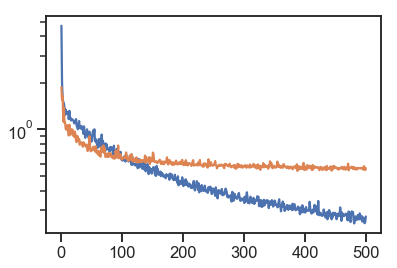

In [11]:
# Plot the training / validation loss for the model
log = pd.read_csv('layer_runs2/n_message_6/log.csv')
plt.semilogy(log.set_index('epoch'))

Load the model and predict the train, validation, and test set inputs

In [12]:
from keras.models import load_model
from nfp import custom_layers, GraphModel
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    model = load_model('layer_runs/n_message_6/best_model.hdf5', custom_objects=custom_layers)
    
embedding_model = GraphModel(model.inputs, [model.layers[-3].input])
# model.summary()

In [13]:
model.layers[-4].output

<tf.Tensor 'add_12/add:0' shape=(?, 128) dtype=float32>

In [15]:
from preprocessor_utils import ConcatGraphSequence

new_pred = model.predict_generator(
    ConcatGraphSequence(inputs_new, batch_size=128, shuffle=False), verbose=1)

8/8 [==============================] - 2s 240ms/step


This block transforms the ambiguous model outputs into a Pandas dataframe with the bond_index and molecule attributes; which allows us to compare the predicted BDEs against ones we've previously calculated.

In [16]:
def inputs_to_dataframe(smiles, inputs):
    molecule = np.repeat(np.array(smiles), np.stack([iinput['n_bond'] for iinput in inputs]))
    bond_index = np.concatenate([iinput['bond_indices'] for iinput in inputs])
    input_df = pd.DataFrame(np.vstack([molecule, bond_index]).T, columns=['molecule', 'bond_index'])
    input_df['bond_index'] = input_df.bond_index.astype('int64')
    
    return input_df

y_new_df = inputs_to_dataframe(test_smiles, inputs_new)
y_new_df['bde_pred'] = new_pred

In [17]:
y_new_df.shape

(39812, 3)

In [12]:
train_df = preprocessor_data['train_df']
valid_df = preprocessor_data['valid_df']

train_df['bde_pred'] = train_pred
valid_df['bde_pred'] = valid_pred

In [13]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=(
    ('PCA', PCA(n_components=10)),
    ('NearestNeighbors', NearestNeighbors(n_neighbors=5))
))

pipe.fit(train_embeddings[preprocessor_data['train_df'].bde.notnull()])

def pipe_kneighbors(pipe, X):
    Xt = pipe.steps[0][-1].transform(X)
    return pipe.steps[-1][-1].kneighbors(Xt)

(array([  38.,  999., 1265., 1353., 2560., 6091., 9302., 7493., 9647.,
        1106.]),
 array([-6.75042826, -5.61687463, -4.483321  , -3.34976738, -2.21621375,
        -1.08266013,  0.0508935 ,  1.18444713,  2.31800075,  3.45155438,
         4.58510801]),
 <a list of 10 Patch objects>)

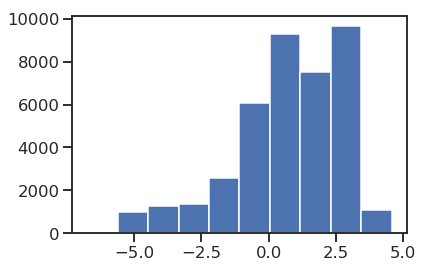

In [14]:
valid_distances, valid_indices = pipe_kneighbors(
    pipe, valid_embeddings)

valid_df['distance'] = np.log(valid_distances).mean(1)
plt.hist(valid_df.distance)

(array([ 131., 1132., 1121., 1539., 3119., 6747., 9061., 7126., 9058.,
         778.]),
 array([-6.33963842, -5.24160452, -4.14357063, -3.04553673, -1.94750284,
        -0.84946894,  0.24856495,  1.34659885,  2.44463274,  3.54266664,
         4.64070053]),
 <a list of 10 Patch objects>)

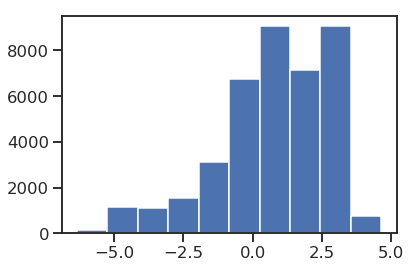

In [15]:
test_distances, test_indices = pipe_kneighbors(
    pipe, test_embeddings)

y_new_df['distance'] = np.log(test_distances).mean(1)
plt.hist(y_new_df.distance)

Here we load calculated BDE values for all molecules, and merge the BDE database on the predicted DataFrame on the molecule and bond_index fields (these should be deterministic)

In [18]:
# Each bond in my model is predicted twice -- here we group by molecule
# and bond_index and take the mean of both predictions, getting one prediction
# for each BDE.
test_predictions = y_new_df.groupby(['molecule', 'bond_index']).mean().reset_index()
test_predictions.head()

bde = pd.read_csv('rdf_data_190531.csv.gz', index_col=0)
test_predictions = test_predictions.merge(
    bde, how='left', left_on=['bond_index', 'molecule'],
    right_on=['bond_index', 'molecule'])

test_predictions.head()

,molecule,bond_index,bde_pred,fragment1,fragment2,bde,bond_type,delta_stereo
0,C#C/C(C)=C/CNCC,0,119.406670,NaN,NaN,NaN,NaN,NaN
1,C#C/C(C)=C/CNCC,1,133.739792,[C]#C,C[C]=CCNCC,132.918956,C-C,0.0
2,C#C/C(C)=C/CNCC,2,91.279968,C#C/[C]=C/CNCC,[CH3],90.545156,C-C,0.0
3,C#C/C(C)=C/CNCC,3,98.873428,NaN,NaN,NaN,NaN,NaN
4,C#C/C(C)=C/CNCC,4,93.479187,[CH2]NCC,[CH]=C(C)C#C,92.585188,C-C,0.0


In [23]:
test_predictions.dropna(subset=['bde']).drop_duplicates(subset=['molecule', 'fragment1', 'fragment2']).shape

(6948, 8)

Here we load calculated BDE values for all molecules, and merge the BDE database on the predicted DataFrame on the molecule and bond_index fields (these should be deterministic)

In [17]:
# Each bond in my model is predicted twice -- here we group by molecule
# and bond_index and take the mean of both predictions, getting one prediction
# for each BDE.
test_predictions = y_new_df.groupby(['molecule', 'bond_index']).mean().reset_index()
test_predictions.head()

bde = pd.read_csv('rdf_data_190531.csv.gz', index_col=0)
test_predictions = test_predictions.merge(
    bde, how='left', left_on=['bond_index', 'molecule'],
    right_on=['bond_index', 'molecule'])

test_predictions.head()

,molecule,bond_index,bde_pred,distance,fragment1,fragment2,bde,bond_type,delta_stereo
0,C#C/C(C)=C/CNCC,0,119.406677,3.317340,NaN,NaN,NaN,NaN,NaN
1,C#C/C(C)=C/CNCC,1,133.739777,1.239395,[C]#C,C[C]=CCNCC,132.918956,C-C,0.0
2,C#C/C(C)=C/CNCC,2,91.279968,1.317526,C#C/[C]=C/CNCC,[CH3],90.545156,C-C,0.0
3,C#C/C(C)=C/CNCC,3,98.873421,3.241231,NaN,NaN,NaN,NaN,NaN
4,C#C/C(C)=C/CNCC,4,93.479187,2.526586,[CH2]NCC,[CH]=C(C)C#C,92.585188,C-C,0.0


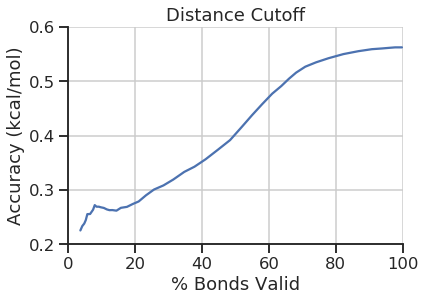

In [18]:
threshs = np.linspace(-4, 4)

acc = []
valid_percent = []

for thres in threshs:
    acc += [(valid_df[valid_df.distance < thres].bde -
             valid_df[valid_df.distance < thres].bde_pred).abs().mean()]
    valid_percent += [(valid_df.distance < thres).sum() / len(valid_df) * 100]


plt.plot(valid_percent, acc)
plt.ylabel('Accuracy (kcal/mol)')  
plt.xlabel('% Bonds Valid')
plt.xlim([0, 100])
plt.ylim([.2, .6001])

plt.grid()
plt.title('Distance Cutoff')
sns.despine(trim=True)

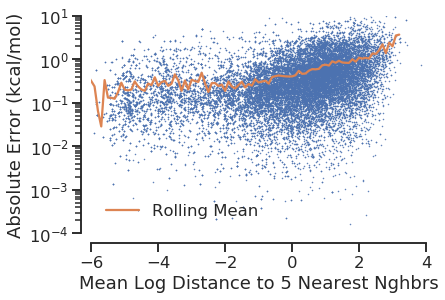

In [19]:
plt.semilogy(valid_df['distance'],
             (valid_df['bde'] - valid_df['bde_pred']).abs(),
             '.', ms=1)
plt.semilogy((valid_df['bde'] - valid_df['bde_pred']).abs().groupby(
    valid_df.distance.round(1)).mean(), label='Rolling Mean')
plt.ylim([1E-4, 1E1])
plt.xlim([-6, 4])

plt.ylabel('Absolute Error (kcal/mol)')
plt.xlabel('Mean Log Distance to 5 Nearest Nghbrs')

plt.legend(loc='lower left')

sns.despine(trim=True, offset=10)

Plot the parity of held-out data predictions

In [20]:
to_follow = [3, 2, 8, 19, 4, 16, 43, 7]
chosen_bonds = train_df[
    train_df.bde.notnull() &
    train_df.preprocessor_class.isin(to_follow)].sample(
    5000, random_state=1)

### Get 1st, 3rd, and 6th bond embeddings

In [21]:
layer_df = pd.DataFrame(((l.name, l) for l in model.layers), columns=['name', 'layer'])
layer_df = layer_df.set_index('name').layer
layer_df.head()

name
bond                     <keras.engine.input_layer.InputLayer object at...
atom                     <keras.engine.input_layer.InputLayer object at...
squeeze_1                <nfp.layers.layers.Squeeze object at 0x7febe94...
atom_embedding           <keras.layers.embeddings.Embedding object at 0...
batch_normalization_1    <keras.layers.normalization.BatchNormalization...
Name: layer, dtype: object

In [22]:
embedding_model_1 = GraphModel(model.inputs, [layer_df['add_2'].output])
embedding_model_3 = GraphModel(model.inputs, [layer_df['add_6'].output])
embedding_model_6 = GraphModel(model.inputs, [layer_df['add_12'].output])

In [23]:
train_embeddings_1 = embedding_model_1.predict_generator(
    ConcatGraphSequence(preprocessor_data['train'][0], batch_size=128, shuffle=False),
    verbose=1)[chosen_bonds.index]
train_embeddings_3 = embedding_model_3.predict_generator(
    ConcatGraphSequence(preprocessor_data['train'][0], batch_size=128, shuffle=False),
    verbose=1)[chosen_bonds.index]
train_embeddings_6 = embedding_model_6.predict_generator(
    ConcatGraphSequence(preprocessor_data['train'][0], batch_size=128, shuffle=False),
    verbose=1)[chosen_bonds.index]

318/318 [==============================] - 3s 9ms/step


In [24]:
from sklearn.manifold import TSNE

pipe = Pipeline(steps=(
    ('PCA', PCA(n_components=10)),
    ('TSNE', TSNE(n_components=2))
))

xt_1 = pipe.fit_transform(train_embeddings_1)
xt_3 = pipe.fit_transform(train_embeddings_3)
xt_6 = pipe.fit_transform(train_embeddings_6)

In [25]:
N = len(to_follow)

In [26]:
xt_1.shape

(5000, 2)

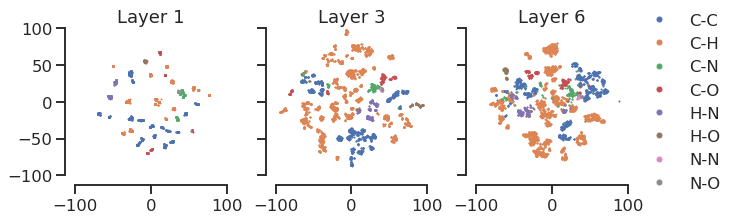

In [37]:
fig, axmatrix = plt.subplots(ncols=3, figsize=(9,3), sharex=True, sharey=True)
#for ax in axmatrix:
#    ax.set_aspect('equal')
    
for bond_type, df in chosen_bonds.reset_index().groupby('bond_type'):
    axmatrix[0].plot(xt_1[df.index, 0], xt_1[df.index, 1], '.', ms=2, zorder=-1)

for bond_type, df in chosen_bonds.reset_index().groupby('bond_type'):
    axmatrix[1].plot(xt_3[df.index, 0], xt_3[df.index, 1], '.', ms=2, zorder=-1)
    
for bond_type, df in chosen_bonds.reset_index().groupby('bond_type'):
    axmatrix[2].plot(xt_6[df.index, 0], xt_6[df.index, 1], '.', ms=2, label=bond_type, zorder=-1)
    
axmatrix[0].set_title('Layer 1')
axmatrix[1].set_title('Layer 3')
axmatrix[2].set_title('Layer 6')

axmatrix[0].set_xlim([-100, 100])
axmatrix[0].set_ylim([-100, 100])

plt.tight_layout()
sns.despine(offset=10)

axmatrix[0].set_rasterization_zorder(0)
axmatrix[1].set_rasterization_zorder(0)
axmatrix[2].set_rasterization_zorder(0)


leg = axmatrix[2].legend(loc='center left', bbox_to_anchor=(1., .5), markerscale=5)
fig.savefig('embeddings.svg', bbox_extra_artists=(leg,), dpi=300)

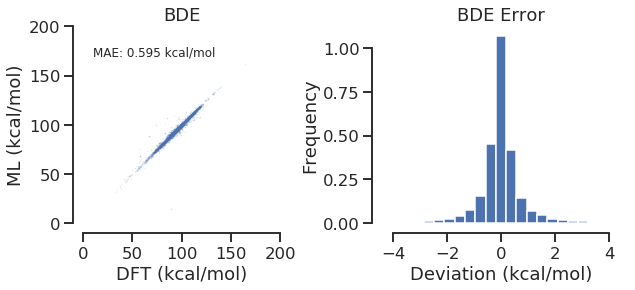

In [28]:
fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(121, aspect='equal')
ax1.plot(test_predictions.bde, test_predictions.bde_pred, '.', ms=1, alpha=.1, rasterized=True)
#ax1.plot(y_valid_df.bde, y_valid_df.bde_pred, '.', ms=1, alpha=0.1)

ax2 = fig.add_subplot(122)
ax2.hist((test_predictions.bde - test_predictions.bde_pred).dropna(), bins=21, range=(-4, 4), density=True)

# hpd = pm.hpd((test_predictions.bde - test_predictions.bde_pred).dropna())
# ax2.axvline(hpd[0], color='.8', zorder=0, ls='--')
# ax2.axvline(hpd[1], color='.8', zorder=0, ls='--')

ax2.set_xticks([-4, -2, 0, 2, 4])
# ax2.set_xlim([-4, 4])

ax1.set_xticks([0, 50, 100, 150, 200])
ax1.set_yticks([0, 50, 100, 150, 200])

mae = (test_predictions.bde - test_predictions.bde_pred).abs().mean()
ax1.text(0.05, .9, "MAE: {0:.3f} kcal/mol".format(mae), ha='left', va='top',
         transform=ax1.transAxes, fontsize='large')

ax1.set_title('BDE')
ax1.set_ylabel('ML (kcal/mol)')
ax1.set_xlabel('DFT (kcal/mol)')

ax2.set_title('BDE Error')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Deviation (kcal/mol)')

plt.tight_layout()
sns.despine(trim=True, offset=10)
plt.savefig('parity.svg', dpi=500)

In [29]:
train_df = preprocessor_data['train_df']
valid_df = preprocessor_data['valid_df']

train_df['bde_pred'] = train_pred
valid_df['bde_pred'] = valid_pred

all_predictions = pd.concat([train_df, valid_df, test_predictions], sort=False).dropna()
all_predictions = all_predictions.drop_duplicates(subset=['molecule', 'bond_index'])

In [30]:
all_predictions['abs_err'] = (all_predictions.bde - all_predictions.bde_pred).abs()
all_predictions.sort_values('abs_err', ascending=False).head()

,bond_index,preprocessor_class,molecule,mol_index,fragment1,fragment2,bde,bond_type,delta_stereo,bde_pred,distance,abs_err
25157,9,3.0,N=c1ccccn1O,631.0,[H],N=c1[c]cccn1O,133.477439,C-H,0.0,114.330391,0.904472,19.147048
28141,13,3.0,C1=CC2C=CC1O2,707.0,[H],C1=CC2C=C[C]1O2,107.252583,C-H,0.0,90.997589,2.893044,16.254994
28131,10,3.0,C1=CC2C=CC1O2,707.0,[H],C1=CC2C=C[C]1O2,107.252583,C-H,0.0,90.997597,2.893044,16.254987
26269,5,2.0,CC(=O)/C=C(\O)C(=O)O,659.0,CC(=O)/C=[C]\O,O=[C]O,110.356243,C-C,0.0,94.709511,2.729132,15.646732
23189,9,3.0,CC(=C\N=O)/C(C)=C/NO,580.0,[H],[CH2]C(=C\N=O)/C(C)=C/NO,71.586227,C-H,0.0,86.206413,1.187391,14.620187


### Code for drawing BDEs

In [31]:
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

def draw_bde(smiles, bond_index, figsize=(300, 300)):
    
    mol = Chem.MolFromSmiles(smiles)
    bond_index = int(bond_index)

    if bond_index >= mol.GetNumBonds():

        molH = Chem.AddHs(mol)
        bond = molH.GetBondWithIdx(bond_index)

        start_atom = mol.GetAtomWithIdx(bond.GetBeginAtomIdx())
        mol = Chem.AddHs(mol, onlyOnAtoms=[start_atom.GetIdx()])
        bond_index = mol.GetNumBonds() - 1

    bond = mol.GetBondWithIdx(bond_index)
    if not mol.GetNumConformers():
        rdDepictor.Compute2DCoords(mol)

    drawer = rdMolDraw2D.MolDraw2DSVG(*figsize)
    drawer.SetFontSize(.6)
    drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=[bond_index,])

    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()

    svg = svg.replace('svg:', '').replace(':svg', '')
    
    return SVG(svg)

In [32]:
all_predictions.sort_values('abs_err', ascending=False)

,bond_index,preprocessor_class,molecule,mol_index,fragment1,fragment2,bde,bond_type,delta_stereo,bde_pred,distance,abs_err
25157,9,3.0,N=c1ccccn1O,631.0,[H],N=c1[c]cccn1O,133.477439,C-H,0.0,114.330391,0.904472,19.147048
28141,13,3.0,C1=CC2C=CC1O2,707.0,[H],C1=CC2C=C[C]1O2,107.252583,C-H,0.0,90.997589,2.893044,16.254994
28131,10,3.0,C1=CC2C=CC1O2,707.0,[H],C1=CC2C=C[C]1O2,107.252583,C-H,0.0,90.997597,2.893044,16.254987
26269,5,2.0,CC(=O)/C=C(\O)C(=O)O,659.0,CC(=O)/C=[C]\O,O=[C]O,110.356243,C-C,0.0,94.709511,2.729132,15.646732
23189,9,3.0,CC(=C\N=O)/C(C)=C/NO,580.0,[H],[CH2]C(=C\N=O)/C(C)=C/NO,71.586227,C-H,0.0,86.206413,1.187391,14.620187
23190,10,3.0,CC(=C\N=O)/C(C)=C/NO,580.0,[H],[CH2]C(=C\N=O)/C(C)=C/NO,71.586227,C-H,0.0,86.206413,1.187391,14.620187
23191,11,3.0,CC(=C\N=O)/C(C)=C/NO,580.0,[H],[CH2]C(=C\N=O)/C(C)=C/NO,71.586227,C-H,0.0,86.206413,1.187391,14.620187
23206,14,3.0,CC(=C\N=O)/C(C)=C/NO,580.0,[H],[CH2]C(=C\NO)/C(C)=C/N=O,101.620690,C-H,0.0,88.105843,1.216409,13.514847
23207,15,3.0,CC(=C\N=O)/C(C)=C/NO,580.0,[H],[CH2]C(=C\NO)/C(C)=C/N=O,101.620690,C-H,0.0,88.105843,1.216409,13.514847
23205,13,3.0,CC(=C\N=O)/C(C)=C/NO,580.0,[H],[CH2]C(=C\NO)/C(C)=C/N=O,101.620690,C-H,0.0,88.105843,1.216409,13.514847


bde         93.65
bde_pred    93.23
Name: 25702, dtype: float64


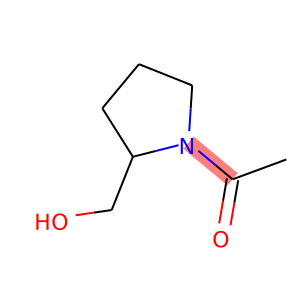

In [33]:
index = 25702
print(all_predictions.loc[index, ['bde', 'bde_pred']].astype(float).round(2))
draw_bde(all_predictions.loc[index, 'molecule'],
         all_predictions.loc[index, 'bond_index'])

bde         104.461
bde_pred    104.608
Name: 23400, dtype: object


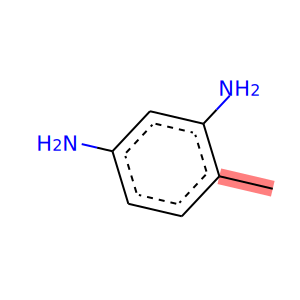

In [34]:
index = 23400
print(all_predictions.loc[index, ['bde', 'bde_pred']])
draw_bde(all_predictions.loc[index, 'molecule'],
         all_predictions.loc[index, 'bond_index'])